In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow import keras

import seaborn as sns
import matplotlib as mp
%matplotlib inline
import math
import numpy as np
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range


import matplotlib.pyplot as plt
import sklearn.metrics

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


"""this is important because i realized the model might not reset"""
tf.keras.backend.clear_session()

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)

TensorFlow version:  2.1.0


# Table of contents
1. [Normal Model](#introduction)
2. [Custom Model I](#model1)
3. [Custom Model II](#model2)

In [2]:
np.random.seed(7)

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [4]:
x2_train = x_train[..., tf.newaxis]
x2_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices((x2_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x2_test, y_test)).batch(32)

class_names = ['0', '1', '2', '3', '4', 
    '5', '6', '7', '8', '9']

print("Shape: ", x_train[0].shape)
print("Label: ", y_train[0], "->", class_names[y_train[0]])

Shape:  (28, 28)
Label:  5 -> 5


In [5]:
img = np.reshape(x_train[0], (-1, 28, 28, 1))

In [6]:
!rm -rf logs

# Creates a file writer for the log directory. I made it so that different categories contain different stuf
logdir = "logs/sample_data/"
file_writer = tf.summary.create_file_writer(logdir)

with file_writer.as_default():
  images = np.reshape(x_train[0:25], (-1, 28, 28, 1))
  tf.summary.image("25 training data examples", images, max_outputs=25, step=0)

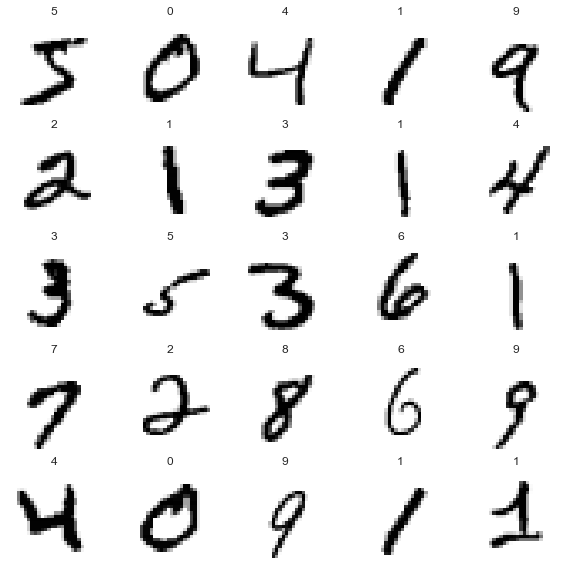

<Figure size 1008x360 with 0 Axes>

In [7]:
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=class_names[y_train[i]])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
  plt.show()
  return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
  tf.summary.image("Training data", plot_to_image(figure), step=0)

# Normal Model <a name="introduction"></a>
* Convolutional Layer w/ RELU activation
* Flattening Layer
* Dense Layer 1 w/ RELU activation
* Dense Layer 2 w/ Linear activation

In [8]:
class ModelOne(Model):
    def __init__(self):
        super(ModelOne, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model=ModelOne()

In [9]:
# It uses crossentropy between the labels and predictions to compute loss.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [11]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [12]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [13]:
!rm -rf logs/gradient_tape

In [14]:
train_log_dir = 'logs/gradient_tape/main_model/train'
test_log_dir = 'logs/gradient_tape/main_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [15]:
EPOCHS = 5

In [16]:
train_loss_results_0 = []
train_accuracy_results_0 = []
test_loss_results_0 = []
test_accuracy_results_0 = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_0.append(train_loss.result())
    train_accuracy_results_0.append(train_acc.result() * 100)
    test_loss_results_0.append(test_loss.result())
    test_accuracy_results_0.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.13440343737602234, Accuracy: 95.95999908447266, Test Loss: 0.06658787280321121, Test Accuracy: 97.81999969482422
Epoch 2, Loss: 0.042444854974746704, Accuracy: 98.66832733154297, Test Loss: 0.0521172396838665, Test Accuracy: 98.01499938964844
Epoch 3, Loss: 0.022384438663721085, Accuracy: 99.3116683959961, Test Loss: 0.04735477268695831, Test Accuracy: 98.19667053222656
Epoch 4, Loss: 0.013165202923119068, Accuracy: 99.5633316040039, Test Loss: 0.0594371035695076, Test Accuracy: 98.2249

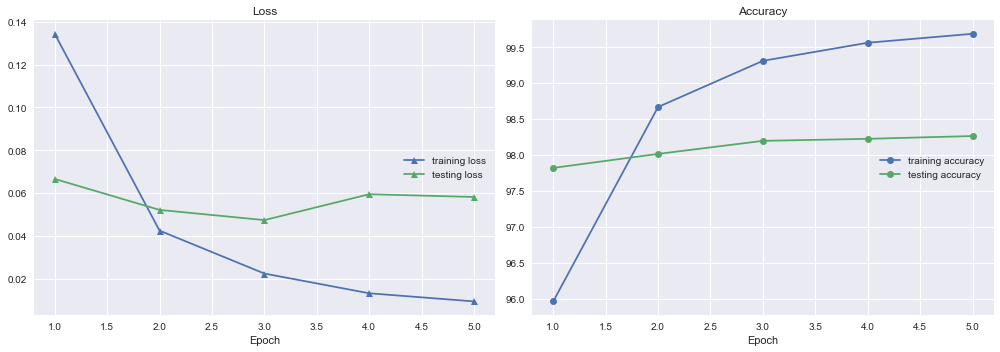

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_0, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_0, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_0, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_0, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=7)
fig.tight_layout()

In [18]:
model.summary()

Model: "model_one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2769024   
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


# Custom Model I <a name="model1"></a>
* Convolutional Layer w/ RELU activation
* Flattening Layer
* Dense Layer w/ Linear activation

In [19]:
class ModelTwo(Model):
    def __init__(self):
        super(ModelTwo, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d2 = Dense(10)
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        return self.d2(x)

model=ModelTwo()

In [20]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [21]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [22]:
train_log_dir = 'logs/gradient_tape/second_model/train'
test_log_dir = 'logs/gradient_tape/second_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [24]:
train_loss_results_1 = []
train_accuracy_results_1 = []
test_loss_results_1 = []
test_accuracy_results_1 = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_1.append(train_loss.result())
    train_accuracy_results_1.append(train_acc.result() * 100)
    test_loss_results_1.append(test_loss.result())
    test_accuracy_results_1.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.12268572300672531, Accuracy: 96.32166290283203, Test Loss: 0.06462469696998596, Test Accuracy: 98.21166229248047
Epoch 2, Loss: 0.05140786990523338, Accuracy: 98.5, Test Loss: 0.06270501017570496, Test Accuracy: 98.16714477539062
Epoch 3, Loss: 0.036468420177698135, Accuracy: 98.89833068847656, Test Loss: 0.05930296704173088, Test Accuracy: 98.1624984741211
Epoch 4, Loss: 0.02480935864150524, Accuracy: 99.26333618164062, Test Loss: 0.06259306520223618, Test Accuracy: 98.1544418334961
Ep

In [25]:
model.summary()

Model: "model_two"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            multiple                  320       
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


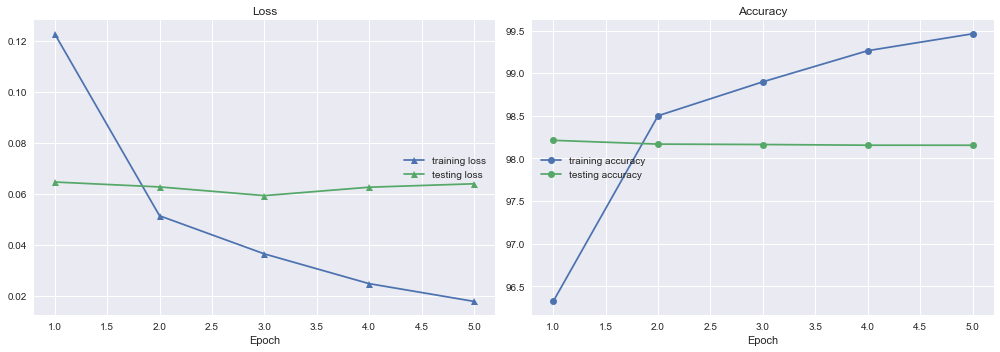

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_1, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_1, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_1, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_1, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=6)
fig.tight_layout()

# Custom Model II  <a name="model2"></a>
* Convolutional Layer w/ Linear Activation
* Flattening Layer
* Dense Layer 1 w/ Linear activation
* Dense Layer 2 w/ Linear activation

In [27]:
class ModelThree(Model):
    def __init__(self):
        super(ModelThree, self).__init__()
        self.conv1 = Conv2D(32, 3)
        self.flatten = Flatten()
        self.d1 = Dense(128)
        self.d2 = Dense(10)
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model=ModelThree()

In [28]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [29]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [30]:
train_log_dir = 'logs/gradient_tape/third_model/train'
test_log_dir = 'logs/gradient_tape/third_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [31]:
train_loss_results_2 = []
train_accuracy_results_2 = []
test_loss_results_2 = []
test_accuracy_results_2 = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_2.append(train_loss.result())
    train_accuracy_results_2.append(train_acc.result() * 100)
    test_loss_results_2.append(test_loss.result())
    test_accuracy_results_2.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.40266504883766174, Accuracy: 89.40499877929688, Test Loss: 0.3424433767795563, Test Accuracy: 97.430908203125
Epoch 2, Loss: 0.3093036413192749, Accuracy: 91.28999328613281, Test Loss: 0.29562458395957947, Test Accuracy: 96.97166442871094
Epoch 3, Loss: 0.29929807782173157, Accuracy: 91.54166412353516, Test Loss: 0.32264629006385803, Test Accuracy: 96.52461242675781
Epoch 4, Loss: 0.2931104302406311, Accuracy: 91.72333526611328, Test Loss: 0.3169478178024292, Test Accuracy: 96.138572692

In [32]:
model.summary()

Model: "model_three"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  320       
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  2769024   
_________________________________________________________________
dense_4 (Dense)              multiple                  1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


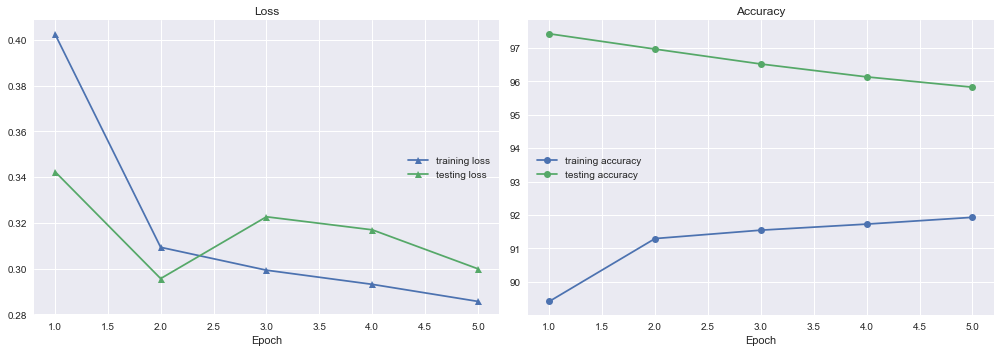

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_2, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_2, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_2, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_2, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=6)
fig.tight_layout()

## Custome Model III
No convolutions in order to create a baseline model

In [ ]:
class ModelFour(Model):
    def __init__(self):
        super(ModelFour, self).__init__()
        self.flat = Flatten()
        self.d1 = Dense(45, activation='relu')
        self.drop = Dropout(0.3)
        self.d2 = Dense(35, activation='relu')
        self.d3 = Dense(23, activation='relu')
#         self.d4 = Dense(10, activation='softmax')
    def call(self, x):
        x = self.flat(x)
        x = self.d1(x)
        x = self.drop(x)
        x = self.d2(x)
#         x = self.d3(x)
        return self.d3(x)

model=ModelFour()

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [ ]:
train_log_dir = 'logs/gradient_tape/third_model/train'
test_log_dir = 'logs/gradient_tape/third_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
train_loss_results_3 = []
train_accuracy_results_3 = []
test_loss_results_3 = []
test_accuracy_results_3 = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_3.append(train_loss.result())
    train_accuracy_results_3.append(train_acc.result() * 100)
    test_loss_results_3.append(test_loss.result())
    test_accuracy_results_3.append(test_acc.result() * 100)

In [ ]:
model.summary()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_3, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_3, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_3, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_3, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=7)
fig.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_0, label='testing loss 0', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_1, label='testing loss 1', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_2, label='testing loss 2', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_3, label='testing loss 3', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_0, label='testing accuracy 0', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_1, label='testing accuracy 1', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_2, label='testing accuracy 2', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_3, label='testing accuracy 3', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend(loc=7)
fig.tight_layout()

In [ ]:
class ModelFour(Model):
    def __init__(self):
        super(ModelFour, self).__init__()
        self.flat = Flatten()
        self.d1 = Dense(45, activation='relu')
        self.drop = Dropout(0.3)
        self.d2 = Dense(35, activation='relu')
        self.d3 = Dense(23, activation='relu')
#         self.d4 = Dense(10, activation='softmax')
    def call(self, x):
        x = self.flat(x)
        x = self.d1(x)
        x = self.drop(x)
        x = self.d2(x)
#         x = self.d3(x)
        return self.d3(x)

model=ModelFour()

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [ ]:
train_log_dir = 'logs/gradient_tape/third_model/train'
test_log_dir = 'logs/gradient_tape/third_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
train_loss_results_3 = []
train_accuracy_results_3 = []
test_loss_results_3 = []
test_accuracy_results_3 = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_3.append(train_loss.result())
    train_accuracy_results_3.append(train_acc.result() * 100)
    test_loss_results_3.append(test_loss.result())
    test_accuracy_results_3.append(test_acc.result() * 100)

In [ ]:
model.summary()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_3, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_3, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_3, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_3, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=7)
fig.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_0, label='testing loss 0', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_1, label='testing loss 1', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_2, label='testing loss 2', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_3, label='testing loss 3', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_0, label='testing accuracy 0', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_1, label='testing accuracy 1', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_2, label='testing accuracy 2', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_3, label='testing accuracy 3', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend(loc=7)
fig.tight_layout()

In [52]:
class ModelFour(Model):
    def __init__(self):
        super(ModelFour, self).__init__()
        self.flat = Flatten()
        self.d1 = Dense(45, activation='relu')
        self.drop = Dropout(0.3)
        self.d2 = Dense(35, activation='relu')
        self.d3 = Dense(23, activation='relu')
#         self.d4 = Dense(10, activation='softmax')
    def call(self, x):
        x = self.flat(x)
        x = self.d1(x)
        x = self.drop(x)
        x = self.d2(x)
#         x = self.d3(x)
        return self.d3(x)

model=ModelFour()

In [53]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [54]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [55]:
train_log_dir = 'logs/gradient_tape/third_model/train'
test_log_dir = 'logs/gradient_tape/third_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [56]:
train_loss_results_3 = []
train_accuracy_results_3 = []
test_loss_results_3 = []
test_accuracy_results_3 = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_3.append(train_loss.result())
    train_accuracy_results_3.append(train_acc.result() * 100)
    test_loss_results_3.append(test_loss.result())
    test_accuracy_results_3.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.4703543186187744, Accuracy: 85.66166687011719, Test Loss: 0.20978836715221405, Test Accuracy: 94.81951904296875
Epoch 2, Loss: 0.3140096962451935, Accuracy: 90.4816665649414, Test Loss: 0.17720849812030792, Test Accuracy: 94.82181549072266
Epoch 3, Loss: 0.2812875211238861, Accuracy: 91.36666870117188, Test Loss: 0.15547430515289307, Test Accuracy: 94.85260772705078
Epoch 4, Loss: 0.26360949873924255, Accuracy: 91.85832977294922, Test Loss: 0.15304437279701233, Test Accuracy: 94.8729171

In [57]:
model.summary()

Model: "model_four_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  35325     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_13 (Dense)             multiple                  1610      
_________________________________________________________________
dense_14 (Dense)             multiple                  828       
Total params: 37,763
Trainable params: 37,763
Non-trainable params: 0
_________________________________________________________________


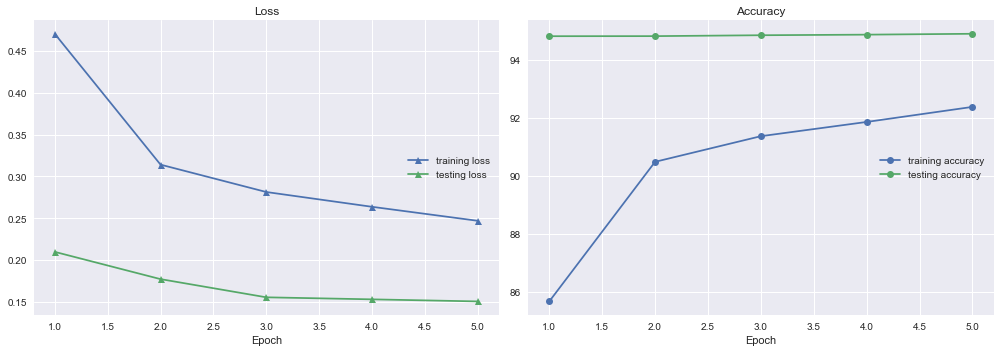

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_3, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_3, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_3, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_3, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=7)
fig.tight_layout()

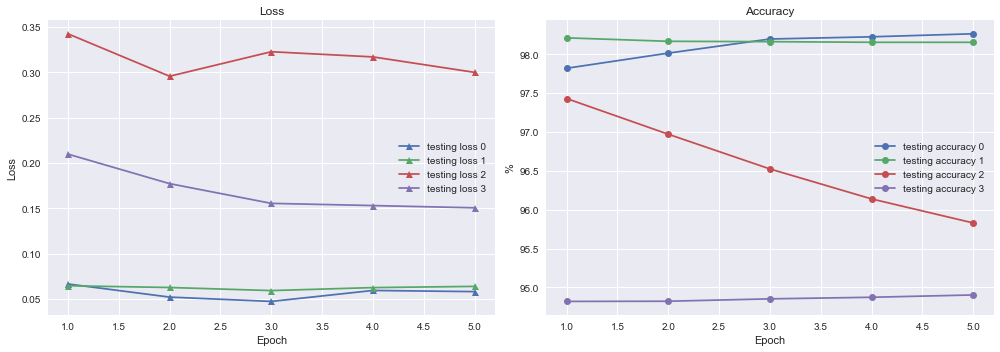

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_0, label='testing loss 0', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_1, label='testing loss 1', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_2, label='testing loss 2', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_3, label='testing loss 3', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_0, label='testing accuracy 0', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_1, label='testing accuracy 1', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_2, label='testing accuracy 2', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_3, label='testing accuracy 3', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend(loc=7)
fig.tight_layout()